# **Multi-GPU Particle Mesh Simulation with Advanced Solvers**

<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/04-MultiGPU_PM_Solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
import os
os.environ["EQX_ON_ERROR"] = "nan"
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jaxpm.kernels import interpolate_power_spectrum
from jaxpm.painting import cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_diffrax_ode
from functools import partial
from diffrax import ConstantStepSize, LeapfrogMidpoint,Dopri5 , PIDController , ODETerm, SaveAt, diffeqsolve

> **Note**: This notebook requires 8 devices (GPU or TPU).\
> If you're running on CPU or don't have access to 8 devices,\
> you can simulate multiple devices by adding the following code at the start **BEFORE IMPORTING JAX**:

```python
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
```

**Recommended only for debugging**. If used, you must probably lower the resolution of the mesh.

In [2]:
assert jax.device_count() >= 8, "This notebook requires a TPU or GPU runtime with 8 devices"

### Setting Up Device Mesh and Sharding for Multi-GPU Simulation

This cell configures a **2x4 device mesh** across 8 devices and sets up named sharding to distribute data efficiently.

- **Device Mesh**: `pdims = (2, 4)` arranges devices in a 2x4 grid. `create_device_mesh(pdims)` initializes this layout across available GPUs.
- **Sharding with Mesh**: `Mesh(devices, axis_names=('x', 'y'))` assigns the mesh grid axes, which allows flexible mapping of array data across devices.
- **PartitionSpec and NamedSharding**: `PartitionSpec` defines data partitioning across mesh axes `('x', 'y')`, and `NamedSharding(mesh, P('x', 'y'))` specifies this sharding scheme for arrays in the simulation.

More info on Sharding in general in [Distributed arrays and automatic parallelization](https://jax.readthedocs.io/en/latest/notebooks/Distributed_arrays_and_automatic_parallelization.html)

In [3]:
from jax.experimental.mesh_utils import create_device_mesh
from jax.experimental.multihost_utils import process_allgather
from jax.sharding import Mesh, NamedSharding
from jax.sharding import PartitionSpec as P

all_gather = partial(process_allgather, tiled=False)

pdims = (2, 4)
devices = create_device_mesh(pdims)
mesh = Mesh(devices, axis_names=('x', 'y'))
sharding = NamedSharding(mesh, P('x', 'y'))

In [ ]:
@partial(jax.jit , static_argnums=(2,3,4,5))
def run_simulation_with_fields(omega_c, sigma8,mesh_shape,box_size,halo_size , snapshots):
    mesh_shape = (mesh_shape,) * 3
    box_size = (box_size,) * 3
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(
        jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape,
                                      box_size,
                                      pk_fn,
                                      seed=jax.random.PRNGKey(0),
                                      sharding=sharding)


    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo,
                   initial_conditions,
                   a=0.1,
                   order=2,
                   halo_size=halo_size,
                   sharding=sharding)

    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)
    ode_fields = [cic_paint_dx(sol[0], halo_size=halo_size, sharding=sharding) for sol in res.ys]
    lpt_field = cic_paint_dx(dx , halo_size=halo_size, sharding=sharding)
    return initial_conditions, lpt_field, ode_fields, res.stats

### Large-Scale Simulation Across Multiple Devices

In this cell, we run a large simulation that would not be feasible on a single device. By distributing data across multiple devices, we achieve a higher resolution (`mesh_shape = 1024` and `box_size = 1000.`) with effective boundary handling using a `halo_size` of 128.

We gather initial conditions and computed fields from all devices for visualization.


45.6 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


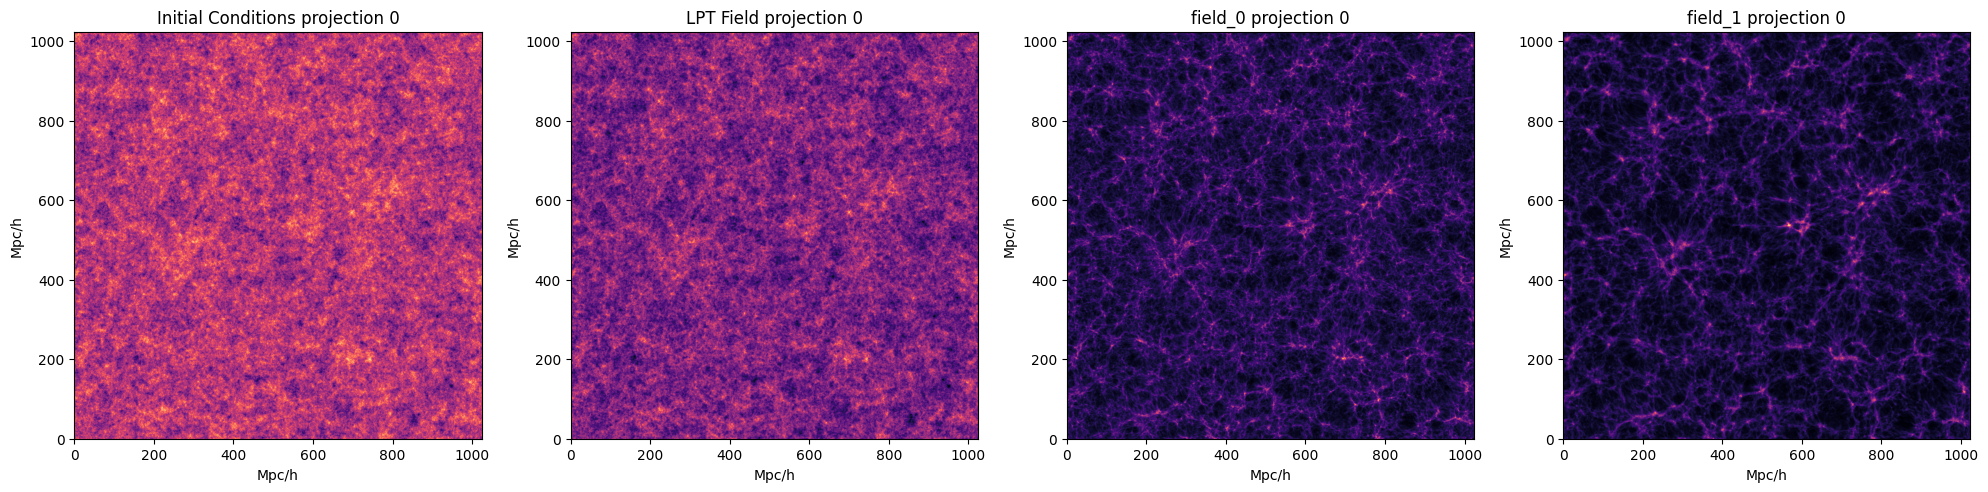

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

mesh_shape = 1024
box_size = 1000.
halo_size = 128
snapshots = (0.5 , 1.0)

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)
ode_fields[-1].block_until_ready()
%timeit initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots);ode_fields[-1].block_until_ready()

initial_conditions_g = all_gather(initial_conditions)
lpt_field_g = all_gather(lpt_field)
ode_fields_g = [all_gather(p) for p in ode_fields]

fields = {"Initial Conditions" : initial_conditions_g , "LPT Field" : lpt_field_g}
for i , field in enumerate(ode_fields_g):
    fields[f"field_{i}"] = field
plot_fields_single_projection(fields,project_axis=0)

This simulation runs in **45 seconds** (less than half a second per step), which is impressive for a setup with **over one billion particles** (since \( 1024^3 \approx 1.07 \) billion). This performance demonstrates the efficiency of distributing data and computation across multiple devices.


### Comparing ODE Solvers: Leapfrog vs. Dopri5

Next, we compare the **Leapfrog** solver with **Dopri5** (an adaptive Runge-Kutta method) to observe differences in accuracy and performance for particle evolution.


In [11]:
mesh_shape = 512
box_size = 512.
halo_size = 64
snapshots = (0.5 , 1.0)

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)
ode_fields[-1].block_until_ready()
%timeit initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_fields(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots);ode_fields[-1].block_until_ready()

5.04 s ± 9.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
mesh_shape = 512
box_size = 512.
halo_size = 64
snapshots = (0.5, 1.0)

@partial(jax.jit , static_argnums=(2,3,4,5))
def run_simulation_with_dopri(omega_c, sigma8,mesh_shape,box_size,halo_size , snapshots):
    mesh_shape = (mesh_shape,) * 3
    box_size = (box_size,) * 3
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(
        jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: interpolate_power_spectrum(x, k, pk, sharding)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape,
                                      box_size,
                                      pk_fn,
                                      seed=jax.random.PRNGKey(0),
                                      sharding=sharding)


    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

    # Initial displacement
    dx, p, f = lpt(cosmo,
                   initial_conditions,
                   a=0.1,
                   order=2,
                   halo_size=halo_size,
                   sharding=sharding)

    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(cosmo, mesh_shape, paint_absolute_pos=False))
    solver = Dopri5()

    stepsize_controller = PIDController(rtol=1e-5,atol=1e-5)
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)
    ode_fields = [cic_paint_dx(sol[0], halo_size=halo_size, sharding=sharding) for sol in res.ys]
    lpt_field = cic_paint_dx(dx , halo_size=halo_size, sharding=sharding)
    return initial_conditions, lpt_field, ode_fields, res.stats

initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_dopri(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots)
ode_fields[-1].block_until_ready()
%timeit initial_conditions , lpt_field , ode_fields , solver_stats = run_simulation_with_dopri(0.25, 0.8 , mesh_shape, box_size , halo_size , snapshots);ode_fields[-1].block_until_ready()

print(f"Solver Stats : {solver_stats}")

4.44 s ± 8.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(12, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(12, dtype=int32, weak_type=True)}


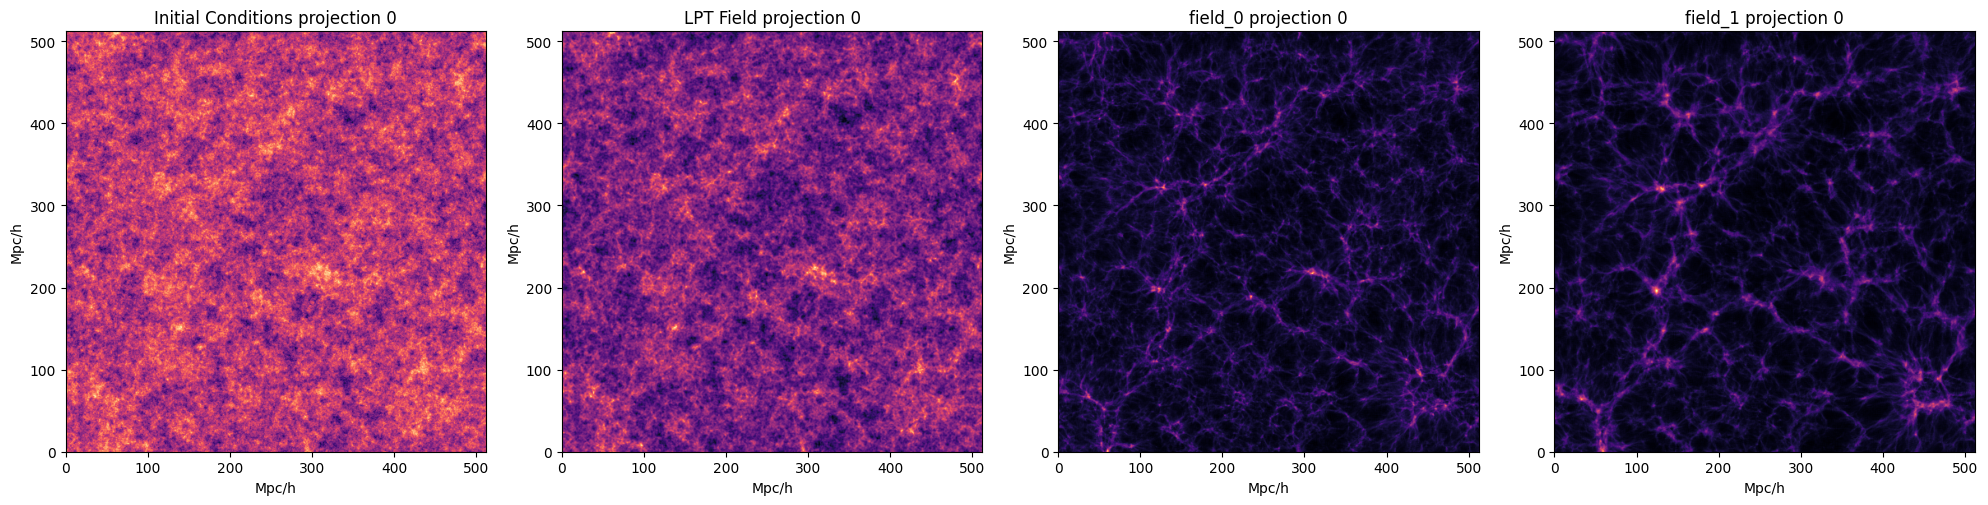

In [10]:
initial_conditions_g = all_gather(initial_conditions)
lpt_field_g = all_gather(lpt_field)
ode_fields_g = [all_gather(p) for p in ode_fields]

fields = {"Initial Conditions" : initial_conditions_g , "LPT Field" : lpt_field_g}
for i , field in enumerate(ode_fields_g):
    fields[f"field_{i}"] = field
plot_fields_single_projection(fields,project_axis=0)

We can see how **easily we can switch solvers** here. Although Dopri5 offers adaptive stepping, it didn’t yield a significant performance boost over Leapfrog in this case.

> **Note**: Dopri5 uses a **PIDController** for adaptive stepping, which might face challenges in distributed setups. In my experience, it works well without triggering all-gathers, but make sure to set:
> ```python
> os.environ["EQX_ON_ERROR"] = "nan"
> ```
> before importing `diffrax` to handle any errors gracefully.

However, **Dopri5 requires more memory** than Leapfrog, making a $1024^3$ mesh simulation unfeasible on eight A100 GPUs with 80GB memory each!!. For larger setups, we’ll need more compute resources—this is covered in the final notebook, **05-MultiHost_PM.ipynb**.
